# From the normal model to regression

##### Keywords: bayesian, normal-normal model, conjugate prior, MCMC engineering, pymc3, regression

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

The example we use here is described in McElreath's book, and our discussion mostly follows the one there, in sections 4.3 and 4.4. 

## Howell's data

These are census data for the Dobe area !Kung San (https://en.wikipedia.org/wiki/%C7%83Kung_people). Nancy Howell conducted detailed quantitative studies of this Kalahari foraging population in the 1960s.

In [2]:
df = pd.read_csv('data/Howell1.csv', sep=';', header=0)
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
df.tail()

,height,weight,age,male
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0
542,71.120,8.051258,0.0,1
543,158.750,52.531624,68.0,1


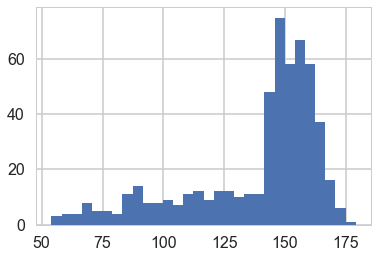

In [4]:
plt.hist(df.height, bins=30);

We get rid of the kids and only look at the heights of the adults.

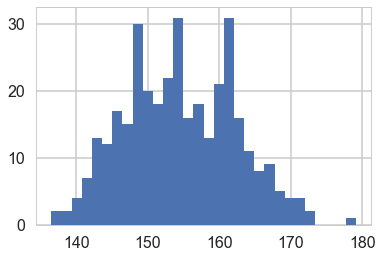

In [5]:
df2 = df[df.age >= 18]
plt.hist(df2.height, bins=30);

## Model for heights

We will now get relatively formal in specifying our models.

We will use a Normal model, $h \sim N(\mu, \sigma)$, and assume that the priors are independent. That is $p(\mu, \sigma) = p(\mu \vert \sigma) p(\sigma) = p(\mu)p(\sigma)$.

Our model is:

$$
h \sim N(\mu, \sigma)\\
\mu \sim Normal(148, 20)\\
\sigma = Std. dev.
$$

In [6]:
from scipy.stats import norm
Y = df2.height.values
#Data Quantities
sig = np.std(Y) # assume that is the value of KNOWN sigma (in the likelihood)
mu_data = np.mean(Y)
n = len(Y)
print("sigma", sig, "mu", mu_data, "n", n)

sigma 7.73132668454 mu 154.597092614 n 352


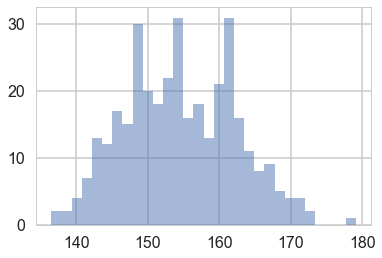

In [12]:
plt.hist(Y, bins=30, alpha=0.5);

In [7]:
# Prior mean
mu_prior = 148
# prior std
tau = 20

In [8]:
kappa = sig**2 / tau**2
sig_post =np.sqrt(1./( 1./tau**2 + n/sig**2));
# posterior mean
mu_post = kappa / (kappa + n) *mu_prior + n/(kappa+n)* mu_data
print("mu post", mu_post, "sig_post", sig_post)

mu post 154.594293158 sig_post 0.41199365493


In [9]:
#samples
N = 15000
theta_prior = np.random.normal(loc=mu_prior, scale=tau, size=N);
theta_post = np.random.normal(loc=mu_post, scale=sig_post, size=N);

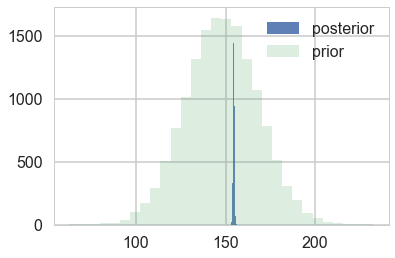

In [263]:
plt.hist(theta_post, bins=30, alpha=0.9, label="posterior");
plt.hist(theta_prior, bins=30, alpha=0.2, label="prior");
#plt.xlim([10, 30])
plt.legend();

In [13]:
Y_postpred = np.random.normal(loc=mu_post, scale=np.sqrt(sig_post**2 + sig**2), size=N);

In [14]:
Y_postpred_sample = np.random.normal(loc=theta_post, scale=sig);

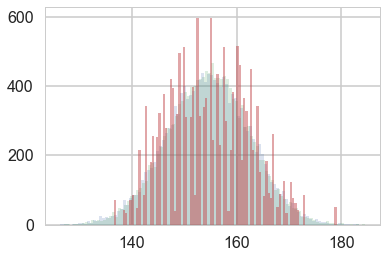

In [22]:
plt.hist(Y_postpred, bins=100, alpha=0.2);
plt.hist(Y_postpred_sample, bins=100, alpha=0.2);
plt.hist(np.random.choice(Y, replace=True, size=N), bins=100, alpha=0.5);

## Regression: adding a predictor

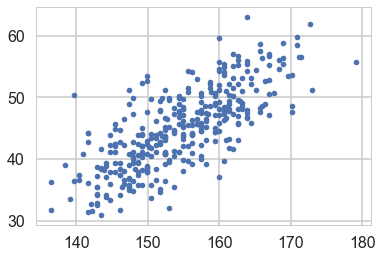

In [21]:
plt.plot(df2.height, df2.weight, '.');

So lets write our model out now:

$$
h \sim N(\mu, \sigma)\\
\mu = intercept + slope \times weight\\
intercept \sim N(150, 100)\\
slope \sim N(0, 10)\\
\sigma = std. dev,
$$

Why should you not use a uniform prior on a slope?

In [49]:
minweight = df2.weight.min()
maxweight = df2.weight.max()
minheight = df2.height.min()
maxheight = df2.height.max()

In [160]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
def cplot(f, ax=None, lims=None):
    if not ax:
        plt.figure()
        ax=plt.gca()
    if lims:
        xx,yy=np.mgrid[lims[0]:lims[1]:lims[2], lims[3]:lims[4]:lims[5]]
    else:
        xx,yy=np.mgrid[0:300:1,-15:15:.1]
    pos = np.empty(xx.shape + (2,))
    pos[:, :, 0] = xx
    pos[:, :, 1] = yy
    ax.contourf(xx, yy, f(pos))
    #data = [x, y]
    return ax
def plotSampleLines(mu, sigma, numberOfLines, dataPoints=None, ax=None):
    #Plot the specified number of lines of the form y = w0 + w1*x in [-1,1]x[-1,1] by
    # drawing w0, w1 from a bivariate normal distribution with specified values
    # for mu = mean and sigma = covariance Matrix. Also plot the data points as
    # blue circles. 
    #print "datap",dataPoints
    if not ax:
        plt.figure()
        ax=plt.gca()
    for i in range(numberOfLines):
        w = np.random.multivariate_normal(mu,sigma)
        func = lambda x: w[0] + w[1]*x
        xx=np.array([minweight, maxweight])
        ax.plot(xx,func(xx),'r', alpha=0.05)
    if dataPoints:
        ax.scatter(dataPoints[0],dataPoints[1], alpha=0.4, s=10)
    #ax.set_xlim([minweight,maxweight])
    #ax.set_ylim([minheight,maxheight])



In [161]:
priorMean = np.array([150, 0])
priorPrecision=2.0
priorCovariance = np.array([[100*100, 0],[0, 10*10]])
priorPDF = lambda w: multivariate_normal.pdf(w,mean=priorMean,cov=priorCovariance)
priorPDF([1,2])

5.1409768989960456e-05

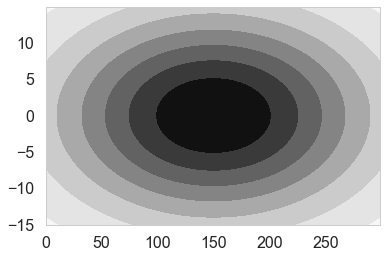

In [162]:
cplot(priorPDF);

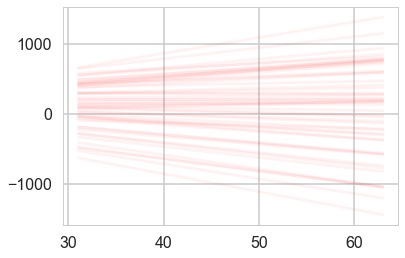

In [166]:
plotSampleLines(priorMean,priorCovariance,50)

In [167]:
likelihoodPrecision = 1./(sig*sig)

### Posterior
We can now continue with the standard Bayesian formalism 

$$
\begin{eqnarray}
 p(\bf w| \bf y,X) &\propto& p(\bf y | X, \bf w) \, p(\bf w) \nonumber \\
                       &\propto& \exp{ \left(- \frac{1}{2 \sigma_n^2}(\bf y-X^T \bf w)^T(\bf y - X^T \bf w) \right)}
                        \exp{\left( -\frac{1}{2} \bf w^T \Sigma^{-1} \bf w \right)}  \nonumber \\ 
\end{eqnarray}
$$
 
In the next step we `complete the square' and obtain 

\begin{equation}
p(\bf w| \bf y,X)  \propto  \exp \left( -\frac{1}{2} (\bf w - \bar{\bf w})^T  (\frac{1}{\sigma_n^2} X X^T + \Sigma^{-1})(\bf w - \bar{\bf w} )  \right)
\end{equation}

This is a Gaussian with inverse-covariance

$$A= \sigma_n^{-2}XX^T +\Sigma^{-1}$$

where the new mean is

$$\bar{\bf w} = A^{-1}\Sigma^{-1}{\bf w_0} + \sigma_n^{-2}( A^{-1} X^T \bf y )$$



To make predictions for a test case we average over all possible parameter predictive distribution
values, weighted by their posterior probability. This is in contrast to non Bayesian schemes, where a single parameter is typically chosen by some criterion. 

In [168]:
# Given the mean = priorMu and covarianceMatrix = priorSigma of a prior
# Gaussian distribution over regression parameters; observed data, x
# and y; and the likelihood precision, generate the posterior
# distribution, postW via Bayesian updating and return the updated values
# for mu and sigma. xtrain is a design matrix whose first column is the all
# ones vector.
def update(x,y,likelihoodPrecision,priorMu,priorCovariance): 
    postCovInv  = np.linalg.inv(priorCovariance) + likelihoodPrecision*np.dot(x.T,x)
    postCovariance = np.linalg.inv(postCovInv)
    postMu = np.dot(np.dot(postCovariance,np.linalg.inv(priorCovariance)),priorMu) + likelihoodPrecision*np.dot(postCovariance,np.dot(x.T,y))
    postW = lambda w: multivariate_normal.pdf(w,postMu,postCovariance)
    return postW, postMu, postCovariance

In [169]:
design = np.concatenate([np.ones(n).reshape(-1,1), df2.weight.values.reshape(-1,1)], axis=1)
response = df2.height.values

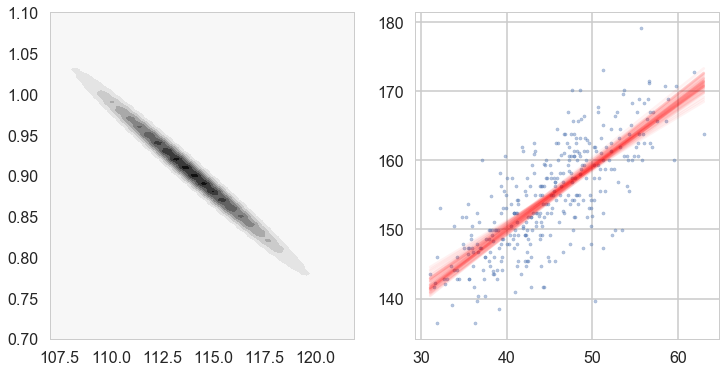

In [171]:
# For each iteration plot  the
# posterior over the first i data points and sample lines whose
# parameters are drawn from the corresponding posterior. 
fig, axes=plt.subplots(figsize=(12,6), nrows=1, ncols=2);
mu = priorMean
cov = priorCovariance
postW,mu,cov = update(design,response,likelihoodPrecision,mu,cov)
cplot(postW, axes[0], lims=[107, 122, 0.1, 0.7, 1.1, 0.01])
plotSampleLines(mu, cov,50, (df2.weight.values,df2.height.values), axes[1])




Lets get the posteriors "at each point"

In [245]:
weightgrid = np.arange(-20, 100)
test_design = np.concatenate([np.ones(len(weightgrid)).reshape(-1,1), weightgrid.reshape(-1,1)], axis=1)

In [255]:
w = np.random.multivariate_normal(mu,cov, 1000) #1000 samples
w[:,0].shape

(1000,)

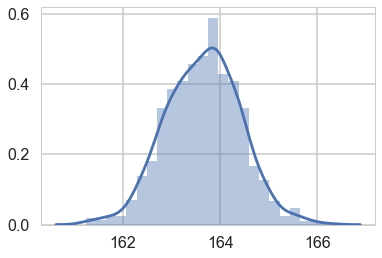

In [264]:
sns.distplot(w[:,0] + w[:,1] * 55) # the weight=55 posterior

In [257]:
mu_pred = np.zeros((len(weightgrid), 1000))
for i, weight in enumerate(weightgrid):
    mu_pred[i, :] = w[:,0] + w[:,1] * weight

post_means = np.mean(mu_pred, axis=1)
post_stds = np.std(mu_pred, axis=1)

(120,)

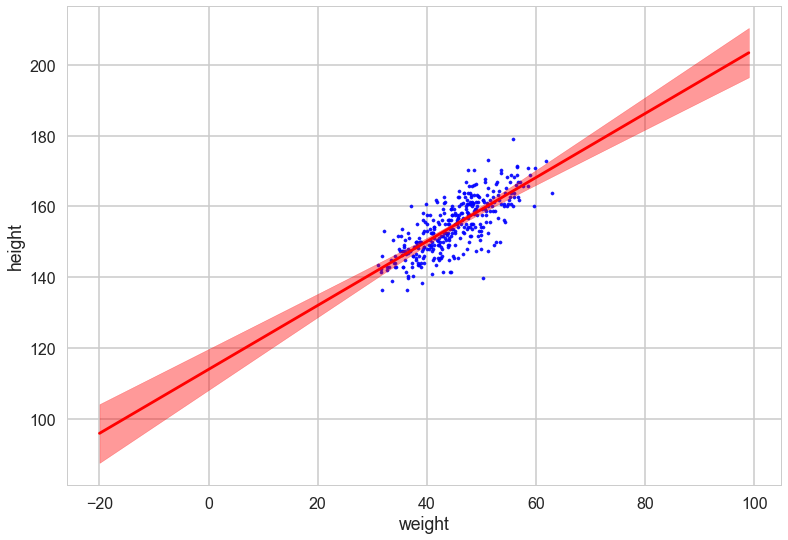

In [258]:
with sns.plotting_context('poster'):
    plt.scatter(df2.weight, df2.height, c='b', alpha=0.9, s=10)
    plt.plot(weightgrid, post_means, 'r')
    #plt.fill_between(weightgrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
    plt.fill_between(weightgrid, post_means - 1.96*post_stds, ppmeans + 1.96*post_stds, color='red', alpha=0.4)


    plt.xlabel('weight')
    plt.ylabel('height')



Oops, what happened here? Our correlations in parameters are huge! But the regression lines do make some sense. Lets look at the posterior predictive.

### Posterior Predictive Distribution

Thus the predictive distribution at some $x^{*}$ is given by averaging the output of all possible linear models w.r.t. the  posterior

$$
\begin{eqnarray} 
p(y^{*} | x^{*}, {\bf x,y}) &=& \int p({\bf y}^{*}| {\bf x}^{*}, {\bf w} ) p(\bf w| X, y)dw \nonumber \\
                                    &=& {\cal N} \left(y \vert \bar{\bf w}^{T}x^{*}, \sigma_n^2 + x^{*^T}A^{-1}x^{*} \right),
\end{eqnarray}
$$


which is again Gaussian, with a mean given by the posterior mean multiplied by the test input
and the variance is a quadratic
form of the test input with the posterior covariance matrix, showing that the
predictive uncertainties grow with the magnitude of the test input, as one would
expect for a linear model. 

In [259]:
ppmeans = np.empty(len(weightgrid))
ppsigs = np.empty(len(weightgrid))
t2 = np.empty(len(weightgrid))



for i, tp in enumerate(test_design):
    ppmeans[i] = mu @ tp
    ppsigs[i] = np.sqrt(sig*sig + tp@cov@tp)
    t2[i] = np.sqrt(tp@cov@tp)

In [268]:
weightgrid[75]

55

(array([   6.,   18.,   62.,  125.,  263.,  239.,  176.,   92.,   16.,    3.]),
 array([ 136.32163732,  141.63972751,  146.9578177 ,  152.27590789,
         157.59399808,  162.91208827,  168.23017846,  173.54826866,
         178.86635885,  184.18444904,  189.50253923]),
 <a list of 10 Patch objects>)

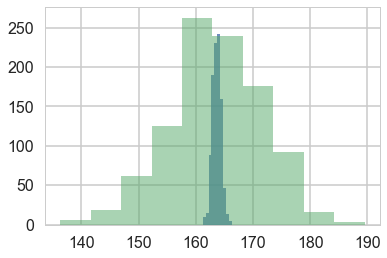

In [270]:
plt.hist(w[:,0] + w[:,1] * 55, alpha=0.8)
plt.hist(norm.rvs(ppmeans[75], ppsigs[75], 1000), alpha=0.5)

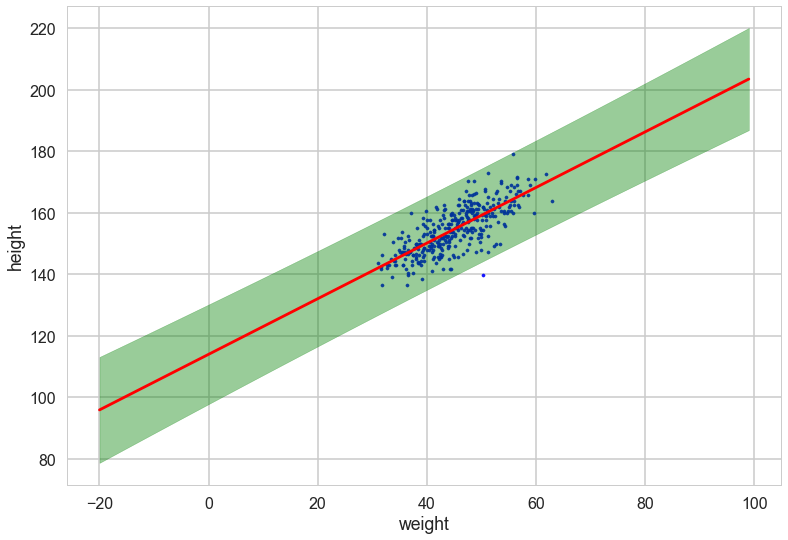

In [249]:
with sns.plotting_context('poster'):
    plt.scatter(df2.weight, df2.height, c='b', alpha=0.9, s=10)
    plt.plot(weightgrid, ppmeans, 'r')
    #plt.fill_between(weightgrid, mu_hpd[:,0], mu_hpd[:,1], color='r', alpha=0.5)
    plt.fill_between(weightgrid, ppmeans - 1.96*ppsigs, ppmeans + 1.96*ppsigs, color='green', alpha=0.4)


    plt.xlabel('weight')
    plt.ylabel('height')


However, by including the $\mu$ as a deterministic in our traces we only get to see the traces at existing data points. If we want the traces on a grid of weights, we'll have to explivitly plug in the intercept and slope traces in the regression formula